In [1]:
import sys
import json
sys.path.append('..')
import torch
from datetime import datetime
from argparse import ArgumentParser
from utils.utils import seed_everything
import torchvision.models as models
import torch.nn as nn
from src import RSNA_DIR
from src.data.rsna_pneumonia_detection import (load_rsna_age_two_split,load_rsna_gender_split)
from torchvision import transforms
from torch.utils.data import DataLoader
import pydicom as dicom
from src.data.datasets import NormalDataset
from torch import Generator
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def init_inception_net():
    model = models.inception_v3(pretrained=True)
    # remove last layer or the model
    model.fc = nn.Identity()
    # print(model)
    return model

In [3]:
def load_dicom_img_custom(filename: str):
    ds = dicom.dcmread(filename)
    img = torch.tensor(ds.pixel_array, dtype=torch.float32) / 255.0
    # repeat dimension two times
    img = img.repeat(3, 1, 1)
    return img  # (3

In [4]:
def load_data(pv, pv_percent):
    if pv == "age":
        print("Loading age split...", "with percent", pv_percent)
        data, labels, meta = load_rsna_age_two_split(
            RSNA_DIR,
            old_percent=pv_percent,
            upsampling_strategy=None,
            effective_dataset_size=1.0
        )
    else:
        print("Loading sex split...", "with percent", pv_percent)
        data, labels, meta = load_rsna_gender_split(
            RSNA_DIR,
            male_percent=pv_percent,
            upsampling_strategy=None,
            effective_dataset_size=1.0
        )
    data_complete = []
    labels_complete = []
    meta_complete = []
    print("Shape of data:", {k: len(v) for k, v in data.items()})
    for k, v in data.items():
        data_complete += v
        labels_complete += labels[k]
        meta_complete += list(meta[k])
    transform = transforms.Compose([
        transforms.Resize(299, antialias=True),
        transforms.CenterCrop(299),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    dataset = NormalDataset(
        data_complete,
        labels_complete,
        meta_complete,
        transform=transform,
        load_fn=load_dicom_img_custom
    )
    print("Total number of images:", len(dataset))
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        num_workers=4,
        generator=Generator().manual_seed(2147483647)
    )
    return dataloader

In [5]:
def run(pv:str, pv_percent:float):
    dataloader = load_data(pv, pv_percent)
    print(f"Setting seed to {1}...")
    seed_everything(1)
    model = init_inception_net()
    model.to("cuda")
    model.eval()
    results = []
    # run inference on all images
    for (img, label, meta) in dataloader:
        img = img.to("cuda")
        with torch.no_grad():
            output = model(img)
            batch_results = [
                {"label": label[i].item(), "meta": meta[i].item(), "output": output[i].tolist()}
                for i in range(len(label))
            ]
            results += batch_results
    return results

In [76]:
pv = "sex"
pv_percent = 0.1
group_mapping = {0:"old", 1:"young"} if pv == "age" else {0:"male",1:"female"}
features = run(pv,pv_percent)

Loading sex split... with percent 0.1
Using 3469 female and 385 male samples for training.
Final dataset shape:  (3854, 4)
Shape of data: {'train': 3854, 'val/lungOpacity_male': 100, 'val/lungOpacity_female': 100, 'test/lungOpacity_male': 100, 'test/lungOpacity_female': 100}
Total number of images: 4254
Setting seed to 1...


/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Group Statistics

In [77]:
# 0 -> old (male), 1 -> young (female)
group_0 = [x for x in features if x["meta"] == 0]
group_1 = [x for x in features if x["meta"] == 1]

In [78]:
group_0_mean = np.mean([x["output"] for x in group_0])
group_1_mean = np.mean([x["output"] for x in group_1])
print(f"{group_mapping[0]} mean:", group_0_mean)
print(f"{group_mapping[1]} mean:", group_1_mean)

male mean: 0.3802240423796663
female mean: 0.36115454923297025


In [79]:
group_0_variance = np.var([x["output"] for x in group_0])
group_1_variance = np.var([x["output"] for x in group_1])
print(f"{group_mapping[0]} variance:", group_0_variance)
print(f"{group_mapping[1]} variance:", group_1_variance)

male variance: 0.13617600060522486
female variance: 0.12798756120850852


# Sample Statistics (per Group)
## Per sample mean

Text(0.5, 1.0, 'Per sample mean')

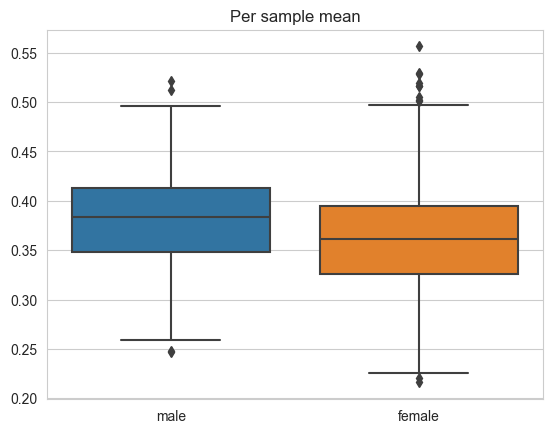

In [80]:
# compute the mean of sample per group
group_0_sample_mean = [np.mean(x["output"]) for x in group_0]
group_1_sample_mean = [np.mean(x["output"]) for x in group_1]
sns.boxplot(data=[group_0_sample_mean, group_1_sample_mean])
# add labels
plt.xticks([0, 1], [group_mapping[0], group_mapping[1]])
plt.title("Per sample mean")

/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

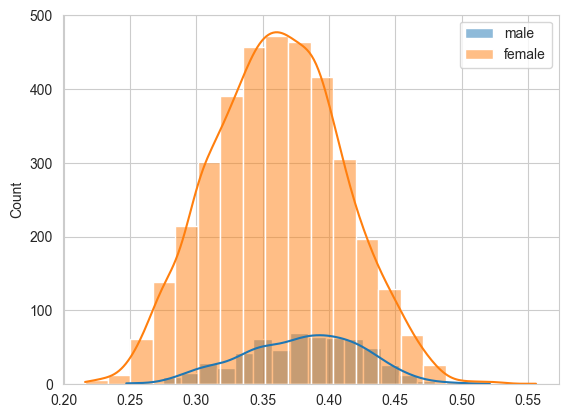

In [81]:
# create histogram of means per group
sns.histplot(data=group_0_sample_mean, bins=20, kde=True, label=group_mapping[0])
sns.histplot(data=group_1_sample_mean, bins=20, kde=True, label=group_mapping[1])
# legend
plt.legend()

## Per sample variance

([<matplotlib.axis.XTick at 0x7fc6624a42b0>,
 [Text(0, 0, 'male'), Text(1, 0, 'female')])

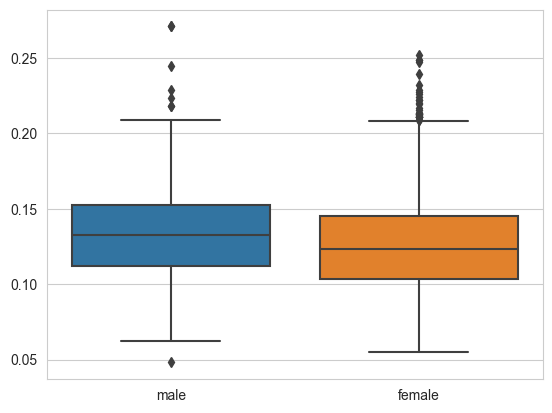

In [82]:
# compute per sample variances per group
group_0_sample_variance = [np.var(x["output"]) for x in group_0]
group_1_sample_variance = [np.var(x["output"]) for x in group_1]
sns.boxplot(data=[group_0_sample_variance, group_1_sample_variance])
# add labels
plt.xticks([0, 1], [group_mapping[0], group_mapping[1]])

/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/getznerj/miniconda3/envs/thesis/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and wil

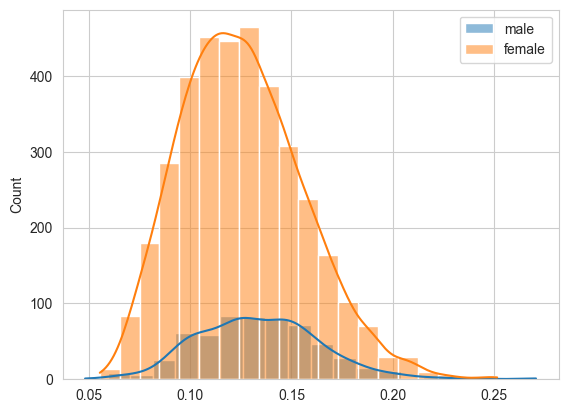

In [83]:
# create histogram of means per group
sns.histplot(data=group_0_sample_variance, bins=20, kde=True, label=group_mapping[0])
sns.histplot(data=group_1_sample_variance, bins=20, kde=True, label=group_mapping[1])
# legend
plt.legend()

In [84]:
per_feature_dim = pd.DataFrame(columns=[f"f{i}" for i in range(len(features[0]["output"]))])
for i in range(len(features[0]["output"])):
    per_feature_dim[f"f{i}"] = [x["output"][i] for x in features]
# split into two df by meta
per_feature_dim["meta"] = [x["meta"] for x in features]
df_group_0 = per_feature_dim[per_feature_dim["meta"] == 0]
df_group_1 = per_feature_dim[per_feature_dim["meta"] == 1]
# drop meta column
df_group_0 = df_group_0.drop(columns=["meta"])
df_group_1 = df_group_1.drop(columns=["meta"])

/tmp/ipykernel_19267/1497606871.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  per_feature_dim["meta"] = [x["meta"] for x in features]


# PCA

In [85]:
from sklearn.decomposition import PCA
pca1 = PCA(n_components=256)
pca2 = PCA(n_components=256)
# mean scale data
pca1.fit((df_group_0 - df_group_0.mean()))
pca2.fit((df_group_1 - df_group_1.mean()))

# Examine explained variance ratios
explained_variance_ratio1 = pca1.explained_variance_ratio_
explained_variance_ratio2 = pca2.explained_variance_ratio_

# Total variance explained
total_variance_explained1 = np.sum(explained_variance_ratio1)
total_variance_explained2 = np.sum(explained_variance_ratio2)

print("\nTotal Variance Explained 1:", total_variance_explained1)
print("Total Variance Explained 2:", total_variance_explained2)


Total Variance Explained 1: 0.9623055366449018
Total Variance Explained 2: 0.9129585122667168


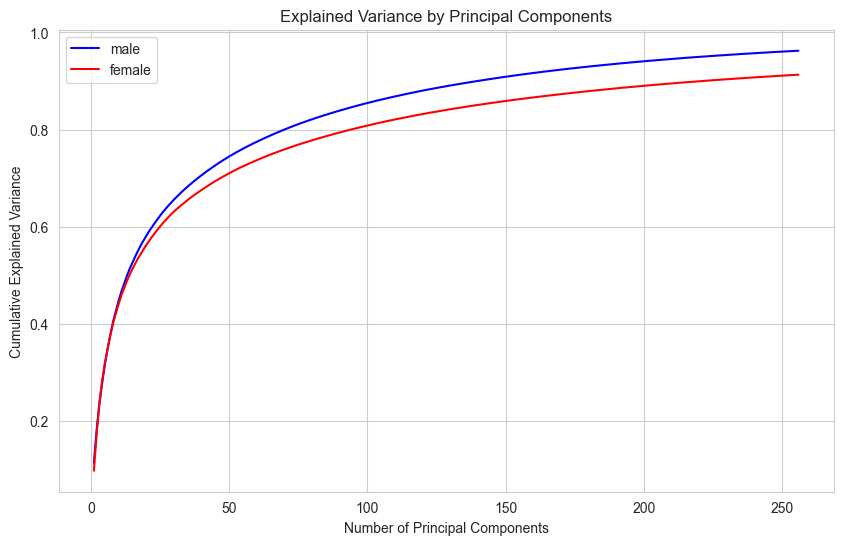

In [86]:

plt.figure(figsize=(10, 6))
plt.plot(range(1, 257), np.cumsum(pca1.explained_variance_ratio_), linestyle='-', color='b')
plt.plot(range(1, 257), np.cumsum(pca2.explained_variance_ratio_), linestyle='-', color='r')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
# add legend
plt.legend([group_mapping[0], group_mapping[1]])
plt.grid(True)
plt.show()

# Entropy

In [87]:
from scipy.stats import entropy
# Calculate entropy for dataset1
entropy0 = entropy(df_group_0.T)  # Transpose to get entropy for each dimension
entropy0_total = np.sum(entropy0)  # Total entropy for the entire dataset

# Calculate entropy for dataset2
entropy1 = entropy(df_group_1.T)
entropy1_total = np.sum(entropy1)

print(f"Entropy for {group_mapping[0]}:", entropy0_total)
print(f"Entropy for {group_mapping[1]}:", entropy1_total)

Entropy for male: 4220.849926993565
Entropy for female: 26423.505081814998


# Analysis of Feature Dimensions (per Group)

In [88]:
rows = []
assert len(group_0) == len(group_1)
for i in range(int(len(features)/2)):
    for k in range(2048):
        new_row = {
            "feature_dim": k,
            "group_0": group_0[i]["output"][k],
            "group_1": group_1[i]["output"][k]
        }
        rows.append(new_row)
temp = pd.DataFrame(rows)
plt.figure(figsize=(10,10))
sns.scatterplot(data=temp, x="group_0", y="group_1", hue="feature_dim")
plt.show()

AssertionError: 

In [ ]:
per_feature_dim_melted = per_feature_dim.melt(id_vars=["meta"], var_name="feature", value_name="value")
# remove "f" from column names and cast to int
per_feature_dim_melted["feature"] = per_feature_dim_melted["feature"].apply(lambda x: int(x[1:]))

In [ ]:
i_prev = 0
for i in range(512,2049,512):
    plt.figure(figsize=(20,10))
    # select only feature dims from i_prev to i
    sub = per_feature_dim_melted[(per_feature_dim_melted["feature"] >= i_prev) & (per_feature_dim_melted["feature"] < i)]
    sns.lineplot(data=sub, x="feature", y="value", hue="meta")
    # change legend labels according to group_mapping
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles=handles, labels=[group_mapping[int(x)] for x in labels])
    i_prev = i
    plt.show()